In [82]:
# import libraries
import urllib.request
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import numpy as np
import os
import seaborn as sns 
import matplotlib.pyplot as plt 
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', None)

path = r"C:\Users\Quyen\OneDrive - GNS Science\Offline_work\11_Github\housepriceprediction"
chrome_path = r"C:\Users\Quyen\OneDrive - GNS Science\Offline_work\11_Github\chromedriver-win64\chromedriver.exe"
os.chdir(path)

In [ ]:
houseprice_url =pd.read_csv("HousepriceURLdunedin.csv")
houseprice = pd.read_csv("Houseprice.csv")
print(f'Number of url {houseprice_url.shape}')
suburb_maps = {'Musselburgh':'other',
 'South Dunedin':'South Dunedin',
 'North Taieri':'other',
 'Fairfield':'other',
 'Saint Kilda':'South Dunedin',
 'Saint Clair':'Expensive surburb',
 'Bradford':'In consideration',
 'Mornington':'In consideration',
 'Dunedin Central':'Expensive surburb',
 'Brighton':'In consideration',
 'Maori Hill':'Expensive surburb',
 'Harington Point':'In consideration',
 'North East Valley':'In consideration',
 'Halfway Bush':'In consideration',
 'Normanby':'In consideration',
 'Mosgiel':'Expensive surburb',
 'Ravensbourne':'In consideration',
 'Glenross':'In consideration',
 'Vauxhall':'In consideration',
 'Kew':'In consideration',
 'Calton Hill':'In consideration',
 'Karitane':'other',
 'Waldronville':'other',
 'Dalmore':'In consideration',
 'Andersons Bay':'In consideration',
 'Waikouaiti':'other',
 'Kaikorai':'In consideration',
 'Helensburgh':'In consideration',
 'Brockville':'In consideration',
 'Waverley':'Expensive surburb',
 'Woodhaugh':'other',
 'Saint Leonards':'In consideration',
 'Pine Hill':'In consideration',
 'Belleknowes':'Expensive surburb',
 'Warrington':'other',
 'Shiel Hill':'In consideration',
 'Balaclava':'In consideration',
 'Liberton':'In consideration',
 'Outram':'Expensive surburb',
 'Green Island':'In consideration',
 'Caversham':'South Dunedin',
 'North Dunedin':'In consideration',
 'Tainui':'other',
 'Roslyn':'Expensive surburb',
 'Blackhead':'other',
 'Mornington':'In consideration',
 'Ocean Grove':'In consideration',
 'Upper Waitati':'other',
 'East Taieri':'other',
 'Green Island':'In consideration',
 'Concord':'In consideration',
 'Wakari':'In consideration',
 'Abbotsford':'In consideration',
}
#Def clean 
def parse_estimated_value(val):
    if pd.isna(val):
        return None
    val = str(val).replace('$', '').replace(',', '').strip().upper()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return None
        
#Clean data
houseprice['product'] = (
    houseprice['product']
    .str.replace('Save this listing', '', regex=False)
    .str.replace('\n', ' ', regex=False)
)
#Extract stress surburb
houseprice[['street', 'suburb', 'city']] = houseprice['title'].str.extract(r'^(.*?),\s*(.*?),\s*(.*?)$')
houseprice['suburb'] = houseprice['suburb'].str.title()
houseprice['suburb_category'] = houseprice['suburb'].map(suburb_maps).fillna('Unknown')

#Clean price method
houseprice['pricing_method'] = (
    houseprice['pricing_method']
    .str.replace('dollar', '', regex=False)
)
#Clean capital value
houseprice['capital_value'] = houseprice['capital_value'].replace(r'[\$,]', '', regex=True).astype(float)
houseprice['land_value'] = houseprice['land_value'].replace(r'[\$,]', '', regex=True).astype(float)
houseprice['improvement_value'] = houseprice['improvement_value'].replace(r'[\$,]', '', regex=True).astype(float)
houseprice['estimated_value_1'] = houseprice['estimated_value_1'].apply(parse_estimated_value)
houseprice['estimated_value_2'] =  houseprice['estimated_value_2'].apply(parse_estimated_value)
houseprice['estimated_value_3'] =  houseprice['estimated_value_3'].apply(parse_estimated_value)
houseprice['estimated_value_4'] = houseprice['estimated_value_4'].apply(parse_estimated_value)
#rename
houseprice.rename(columns={'estimated_value_1':'estimate_value_low',
                           'estimated_value_2':'estimate_value_medium',
                           'estimated_value_3':'estimate_value_high',
                           'confidence_band_4':'latest_valuation_date',
                           'estimated_value_4':'estimate_value_cv'},inplace=True)
houseprice['ratio_capital_value_to_estimate_value'] = houseprice['estimate_value_medium'] / houseprice['capital_value'] 
houseprice['minus_capital_value_to_estimate_value'] = houseprice['estimate_value_medium'] - houseprice['capital_value'] 
#remove duplicate
houseprice.drop_duplicates(subset=['url'],inplace=True)
print(f'Number of url {houseprice.shape}')

Number of url (665, 4)
Number of url (124, 32)


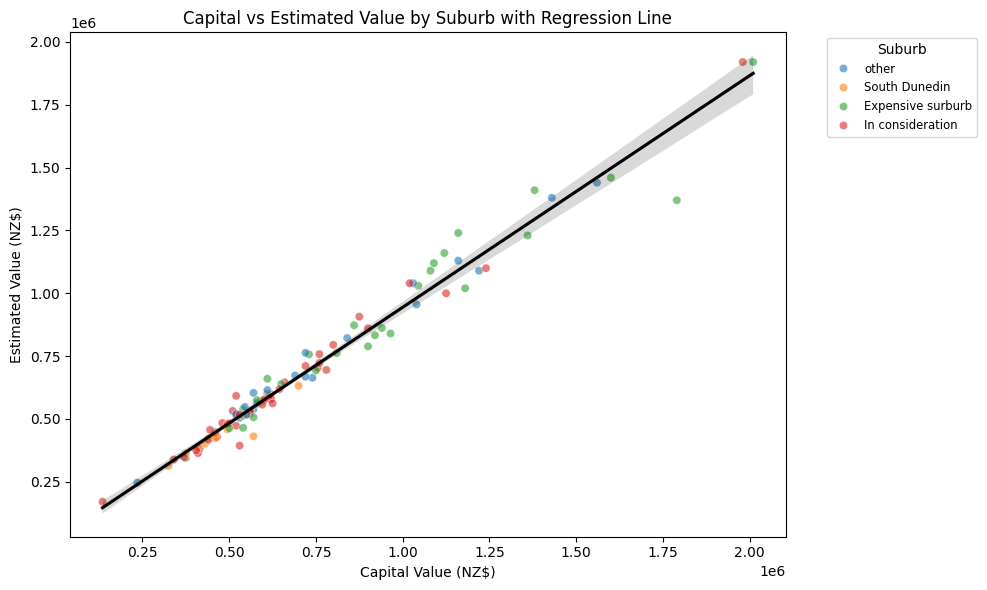

In [106]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=houseprice,
    x='capital_value', 
    y='estimate_value_medium',
    hue='suburb_category',
    alpha=0.6
)

sns.regplot(
    data=houseprice,
    x='capital_value',
    y='estimate_value_medium',
    scatter=False,
    color='black'
)

plt.xlabel('Capital Value (NZ$)')
plt.ylabel('Estimated Value (NZ$)')
plt.title('Capital vs Estimated Value by Suburb with Regression Line')
plt.legend(title='Suburb', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='medium')
plt.tight_layout()
plt.show()

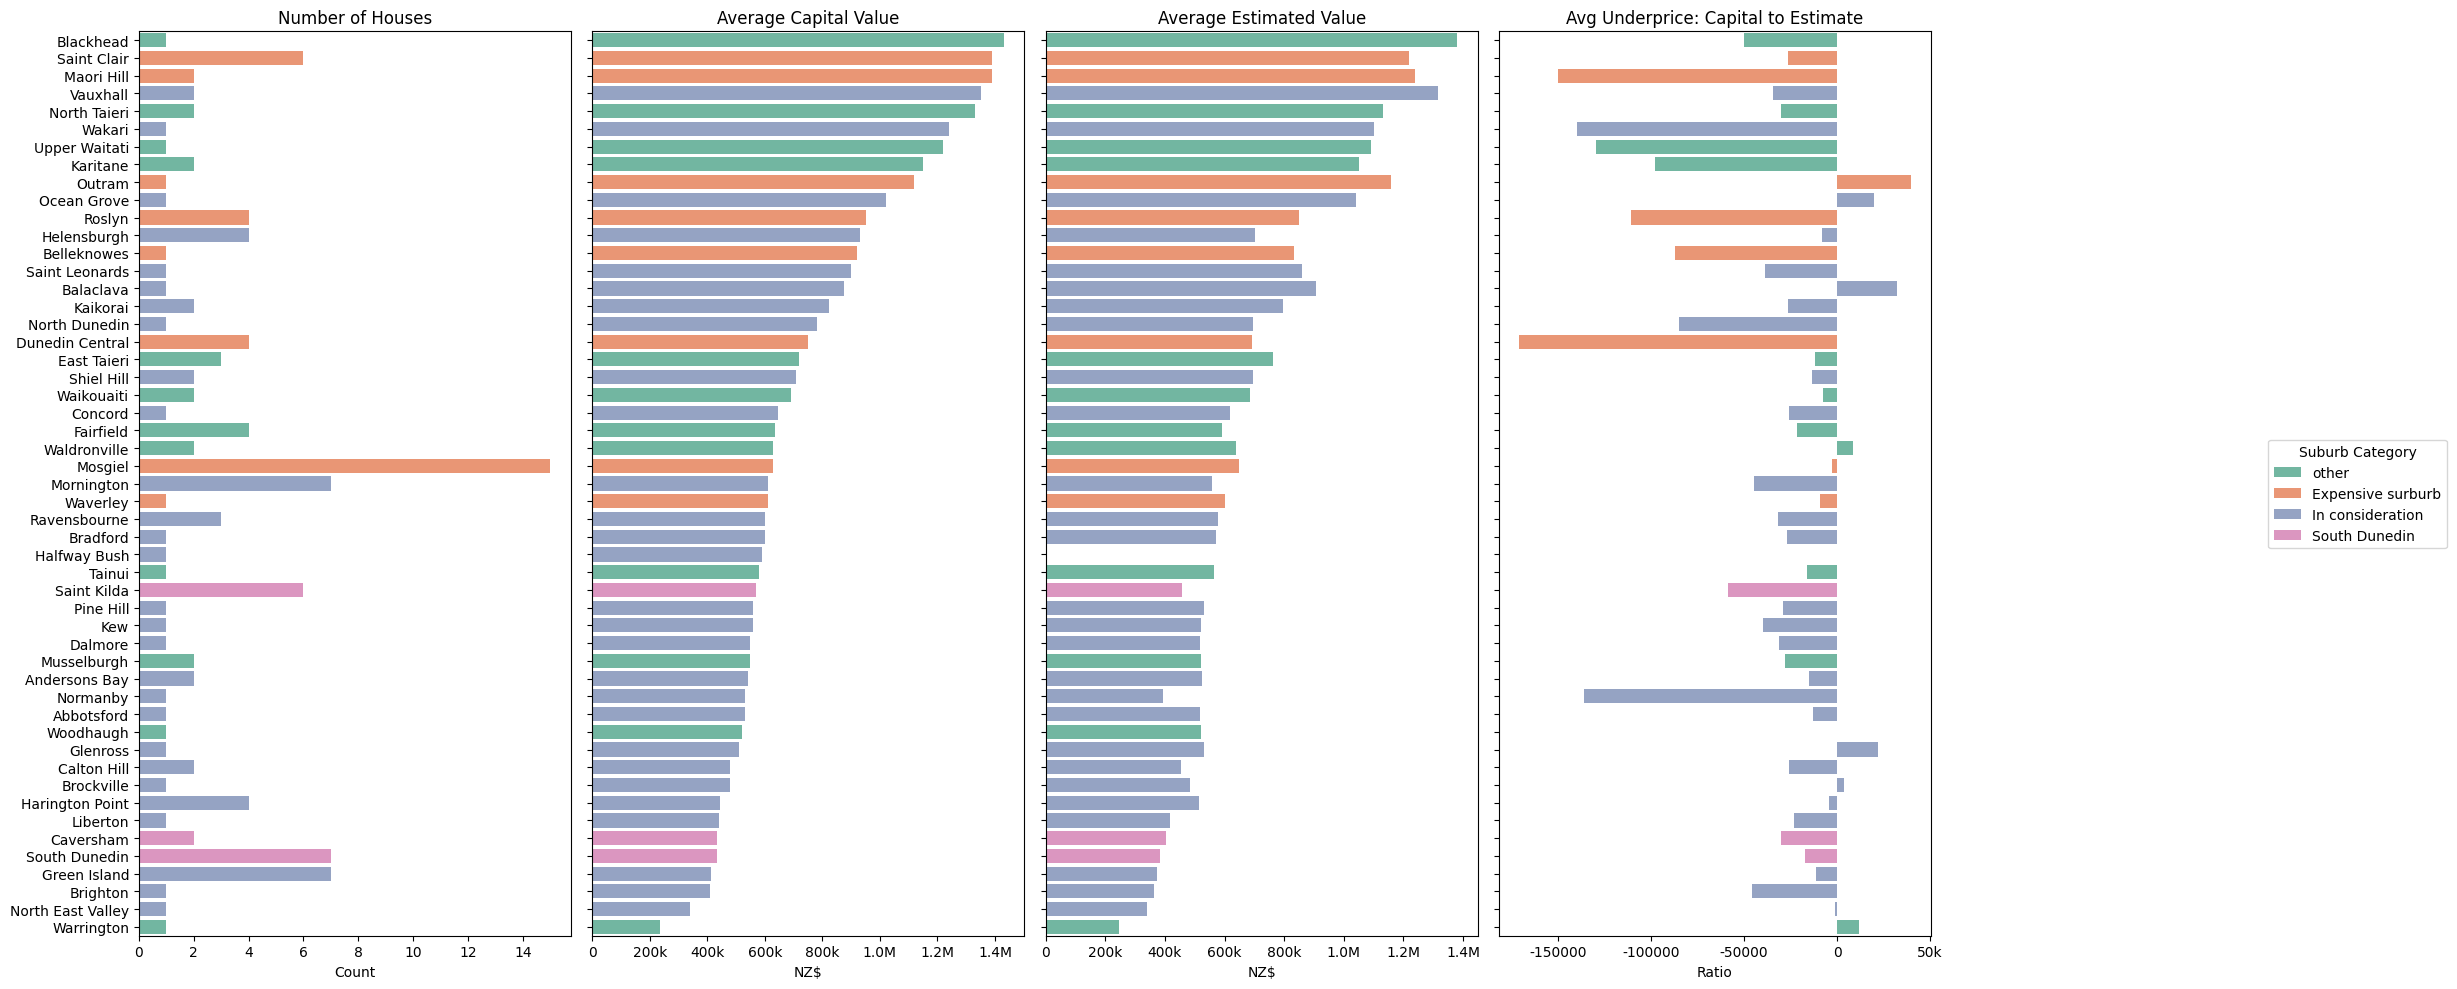

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 1. Group and summarize ---
suburb_summary = houseprice.groupby(['suburb', 'suburb_category']).agg(
    house_count=('suburb', 'count'),
    avg_capital_value=('capital_value', 'median'),
    avg_estimated_value=('estimate_value_medium', 'median'),
    avg_under_capital_value=('minus_capital_value_to_estimate_value', 'mean')
).reset_index()

# Sort by average capital value ratio
suburb_summary = suburb_summary.sort_values('avg_capital_value', ascending=False)

# --- 2. Set up figure and formatters ---
fig, axes = plt.subplots(1, 4, figsize=(22, 10), sharey=True)

# Formatter: 500000 → 500k, 1.2M
def currency_k_m(x, _):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.0f}k'
    else:
        return f'{x:.0f}'

palette = 'Set2'

# --- 3. Plot each subplot with grouped bars ---
sns.barplot(
    data=suburb_summary, 
    x='house_count', 
    y='suburb', 
    hue='suburb_category', 
    ax=axes[0], 
    palette=palette
)
axes[0].set_title('Number of Houses')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('')

sns.barplot(
    data=suburb_summary, 
    x='avg_capital_value', 
    y='suburb', 
    hue='suburb_category', 
    ax=axes[1], 
    palette=palette
)
axes[1].set_title('Average Capital Value')
axes[1].set_xlabel('NZ$')
axes[1].set_ylabel('')
axes[1].xaxis.set_major_formatter(mtick.FuncFormatter(currency_k_m))

sns.barplot(
    data=suburb_summary, 
    x='avg_estimated_value', 
    y='suburb', 
    hue='suburb_category', 
    ax=axes[2], 
    palette=palette
)
axes[2].set_title('Average Estimated Value')
axes[2].set_xlabel('NZ$')
axes[2].set_ylabel('')
axes[2].xaxis.set_major_formatter(mtick.FuncFormatter(currency_k_m))

sns.barplot(
    data=suburb_summary, 
    x='avg_under_capital_value', 
    y='suburb', 
    hue='suburb_category', 
    ax=axes[3], 
    palette=palette
)
axes[3].set_title('Avg Underprice: Capital to Estimate')
axes[3].set_xlabel('Ratio')
axes[3].set_ylabel('')
axes[3].xaxis.set_major_formatter(mtick.FuncFormatter(currency_k_m))

# --- 4. Adjust layout and add legend ---
# Remove duplicate legends
for ax in axes[:]:
    ax.get_legend().remove()

# Place legend to the right of the last plot
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title='Suburb Category', bbox_to_anchor=(1.03, 0.5), loc='center left')

plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()


In [109]:
houseprice.to_csv('Houseprice_clean.csv')

In [ ]:
app = Dash()
# Requires Dash 2.17.0 or later
app.layout = [
    html.H1(children='Title of Dash App', style={'textAlign':'center'}),
    dcc.Dropdown(houseprice.bedroom.unique(), 'Canada', id='dropdown-selection'),
    dcc.Graph(id='graph-content')
]

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)
def update_graph(value):
    dff = houseprice[houseprice.bedroom==value]
    return px.line(dff, x='year', y='pop')

if __name__ == '__main__':
    app.run(debug=True)

[2025-07-06 21:30:14,163] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\Quyen\.conda\envs\geo\Lib\site-packages\flask\app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\Quyen\.conda\envs\geo\Lib\site-packages\flask\app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "c:\Users\Quyen\.conda\envs\geo\Lib\site-packages\dash\dash.py", line 1414, in dispatch
    ctx.run(
    ~~~~~~~^
        functools.partial(
        ^^^^^^^^^^^^^^^^^^
    ...<7 lines>...
        )
        ^
    )
    ^
  File "c:\Users\Quyen\.conda\envs\geo\Lib\site-packages\dash\_callback.py", line 536, in add_context
    raise err
  File "c:\Users\Quyen\.conda\envs\geo\Lib\site-packages\dash\_callback.py", line 525, in add_context
    outpu